# 1 - Introduction


=================================================

Nama : Dicky Gabriel Partogi Sarumpaet

Deskripsi Tugas: Melakukan web scraping pada review tokopedia di google play store.

=================================================

# 2 - Import Library

In [1]:
# Data manipulation libraries
import pandas as pd 
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

# Warning handling
import warnings
warnings.filterwarnings('ignore') #turn off warning

# Text preprocessing libraries
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# ML/DL libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape, SimpleRNN
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import tensorflow_hub as tf_hub
from keras.models import load_model
from keras.utils import custom_object_scope
from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 3 - Data Loading

In [2]:
df = pd.read_excel('scraping_file.xlsx', header=0)

In [3]:
df.drop('Unnamed: 0', axis=1,inplace=True)

In [4]:
df

,userName,review_description,rating,review_date,appVersion,Sentiment
0,Faradilla Putri,informasi tentang kurir yang mengantar paket t...,2,2024-02-16 13:28:16,NaN,0
1,Henry Wijaya,Ribet ngurus komplain. Penyelesaian masalah ti...,1,2024-02-16 13:20:30,3252,0
2,Longlife Teaching,Tolong perbaiki glitch-nya. Mau dipake,2,2024-02-16 11:54:56,3232,0
3,risna habibi,Kecamatan pengiriman nya sangat lambat,1,2024-02-16 11:45:50,3252,0
4,Tjauw njuk lin Lin,Error,1,2024-02-16 11:44:12,NaN,0
...,...,...,...,...,...,...
995,Florence Angel,"Cuma 1 kata yg pantas ""PENIPU"" buat cs tokped....",1,2023-12-28 19:51:46,3.247.1,0
996,Rian Saputra,Harga barang jauh lebih mahal dari toko lain +...,1,2023-12-28 19:26:37,3242,0
997,Aniq Zack,Are kore yasui Kara kattoke Ima dake wa chansu...,5,2023-12-28 17:46:06,3.247.1,1
998,nesha Yurii kirana,😵‍💫😵‍💫😵‍💫,5,2023-12-28 17:41:57,NaN,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   userName            1000 non-null   object        
 1   review_description  1000 non-null   object        
 2   rating              1000 non-null   int64         
 3   review_date         1000 non-null   datetime64[ns]
 4   appVersion          863 non-null    object        
 5   Sentiment           1000 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 47.0+ KB


In [6]:
df = df.fillna("3.252")

# 4 - Feature Engineering

## Preprocessing

In [7]:
def preprocessing(text):
    ''' 
    Preprocessing text by applying lowercasing, normalization, tokenization, stopword removal, and lemmatization
    '''
    # Lowercase the text
    text = text.lower()

    # Normalize the text
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove whitespaces

    # Tokenize the text
    tokens = word_tokenize(text)

    # Get the English stopwords
    stop_words = set(stopwords.words('indonesian'))
    stop_words.update(['the', 'yg', 'gk', 'nyagak', 'pake', 'pakai', 'i', "and"])

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize the text
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Combine tokens back into a single string
    text = ' '.join(tokens)

    return text

# Apply the function to the 'review_description' column in the data
df['review_description'] = df['review_description'].apply(preprocessing)

## Target Conversion into Numbers

In [8]:
df

,userName,review_description,rating,review_date,appVersion,Sentiment
0,Faradilla Putri,informasi kurir mengantar paket menyusahkan me...,2,2024-02-16 13:28:16,3.252,0
1,Henry Wijaya,ribet ngurus komplain penyelesaian netral pdhl...,1,2024-02-16 13:20:30,3252,0
2,Longlife Teaching,tolong perbaiki glitchnya dipake,2,2024-02-16 11:54:56,3232,0
3,risna habibi,kecamatan pengiriman nya lambat,1,2024-02-16 11:45:50,3252,0
4,Tjauw njuk lin Lin,error,1,2024-02-16 11:44:12,3.252,0
...,...,...,...,...,...,...
995,Florence Angel,penipu c tokped case selesai pusat resolusi tg...,1,2023-12-28 19:51:46,3.247.1,0
996,Rian Saputra,harga barang mahal toko free ongkir,1,2023-12-28 19:26:37,3242,0
997,Aniq Zack,are kore yasui kara kattoke ima dake wa chansu...,5,2023-12-28 17:46:06,3.247.1,1
998,nesha Yurii kirana,,5,2023-12-28 17:41:57,3.252,1


## Data Splitting

In [9]:
# Display Target
df.Sentiment.unique()

array([0, 1], dtype=int64)

0 = negative sentiment
1 = positive sentiment 

In [10]:
# split into train+val and test 
X_train_val, X_test, y_train_val, y_test = train_test_split(df.review_description,
                                                    df.Sentiment,
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify=df.Sentiment)

# split into train and val
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                y_train_val,
                                                test_size=0.15,
                                                random_state=42,
                                                stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (680,)
Val Size   :  (120,)
Test Size  :  (200,)


## Encode target

In [11]:
# Change Target to One Hot Encoding
y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [12]:
# Create a CountVectorizer instance
Vectorize = CountVectorizer()

# Fit and transform the training data
X_train_vec = Vectorize.fit_transform(X_train)

# Transform the val data using the same vocabulary as the training data
X_val_vec = Vectorize.transform(X_test)

# Transform the test data using the same vocabulary as the training data
X_test_vec = Vectorize.transform(X_test)

# Get the total number of unique words in the vocabulary
total_vocab = len(Vectorize.vocabulary_.keys())

# Find the maximum sentence length in terms of tokens in the training set
max_sen_len = max([len(i.split(" ")) for i in X_train])

# Display the total vocabulary and maximum sentence length
print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  2889
Maximum Sentence Length :  83 tokens


In [13]:
# Create a TextVectorization layer
text_vectorization = TextVectorization(
    max_tokens=total_vocab,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    ngrams=None,
    output_mode="int",
    output_sequence_length=max_sen_len,
    input_shape=(1,)  # Only used in Sequential API
)

# Adapt the TextVectorization layer to the training data
text_vectorization.adapt(X_train)

## Word Embedding

In [14]:
# Embedding
embedding = Embedding(input_dim=total_vocab,
                    output_dim=128,
                    embeddings_initializer="uniform",
                    input_length=max_sen_len)

In [15]:
## Clear Session
seed = 42
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [16]:
# Define the architecture
model_rnn = Sequential()
model_rnn.add(text_vectorization)
model_rnn.add(embedding)
model_rnn.add(Bidirectional(SimpleRNN(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_rnn.add(Bidirectional(SimpleRNN(16, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_rnn.add(Bidirectional(SimpleRNN(8, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_rnn.add(Dense(2, activation='softmax'))

model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [17]:
model_rnn_hist = model_rnn.fit(X_train, y_train_ohe, epochs=10, validation_data=(X_val, y_val_ohe))

Epoch 1/10


22/22 [==============================] - 16s 205ms/step - loss: 0.5071 - accuracy: 0.7765 - val_loss: 0.4635 - val_accuracy: 0.7917
Epoch 2/10
22/22 [==============================] - 3s 124ms/step - loss: 0.2615 - accuracy: 0.9103 - val_loss: 0.4587 - val_accuracy: 0.8167
Epoch 3/10
22/22 [==============================] - 3s 145ms/step - loss: 0.1101 - accuracy: 0.9735 - val_loss: 0.4361 - val_accuracy: 0.8333
Epoch 4/10
22/22 [==============================] - 3s 134ms/step - loss: 0.0538 - accuracy: 0.9941 - val_loss: 0.4897 - val_accuracy: 0.7917
Epoch 5/10
22/22 [==============================] - 3s 134ms/step - loss: 0.0356 - accuracy: 0.9971 - val_loss: 0.4963 - val_accuracy: 0.8167
Epoch 6/10
22/22 [==============================] - 3s 124ms/step - loss: 0.0216 - accuracy: 0.9985 - val_loss: 0.5145 - val_accuracy: 0.8083
Epoch 7/10
22/22 [==============================] - 3s 122ms/step - loss: 0.0173 - accuracy: 0.9985 - val_loss: 0.5111 - val_accuracy: 0.7917
Epoch 8/10
22/22

In [18]:
## Clear Session
seed = 42
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [19]:
# Define the architecture
model_lstm = Sequential()
model_lstm.add(text_vectorization)
model_lstm.add(embedding)
model_lstm.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm.add(Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm.add(Bidirectional(LSTM(8, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm.add(Dense(2, activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [20]:
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 83)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 83, 128)           369792    
                                                                 
 bidirectional (Bidirection  (None, 83, 64)            41216     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 83, 32)            10368     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 16)                2624      
 onal)                                                  

In [21]:
model_lstm_hist = model_lstm.fit(X_train, y_train_ohe, epochs=10, validation_data=(X_val, y_val_ohe))

Epoch 1/10


22/22 [==============================] - 43s 580ms/step - loss: 0.5977 - accuracy: 0.6868 - val_loss: 0.5439 - val_accuracy: 0.6917
Epoch 2/10
22/22 [==============================] - 5s 218ms/step - loss: 0.4996 - accuracy: 0.7926 - val_loss: 0.4622 - val_accuracy: 0.7583
Epoch 3/10
22/22 [==============================] - 5s 213ms/step - loss: 0.3910 - accuracy: 0.8809 - val_loss: 0.3816 - val_accuracy: 0.8500
Epoch 4/10
22/22 [==============================] - 5s 215ms/step - loss: 0.2360 - accuracy: 0.9676 - val_loss: 0.3484 - val_accuracy: 0.8500
Epoch 5/10
22/22 [==============================] - 5s 210ms/step - loss: 0.1380 - accuracy: 0.9868 - val_loss: 0.2912 - val_accuracy: 0.8917
Epoch 6/10
22/22 [==============================] - 5s 213ms/step - loss: 0.0896 - accuracy: 0.9897 - val_loss: 0.3131 - val_accuracy: 0.8833
Epoch 7/10
22/22 [==============================] - 5s 215ms/step - loss: 0.0655 - accuracy: 0.9926 - val_loss: 0.3196 - val_accuracy: 0.8917
Epoch 8/10
22/22

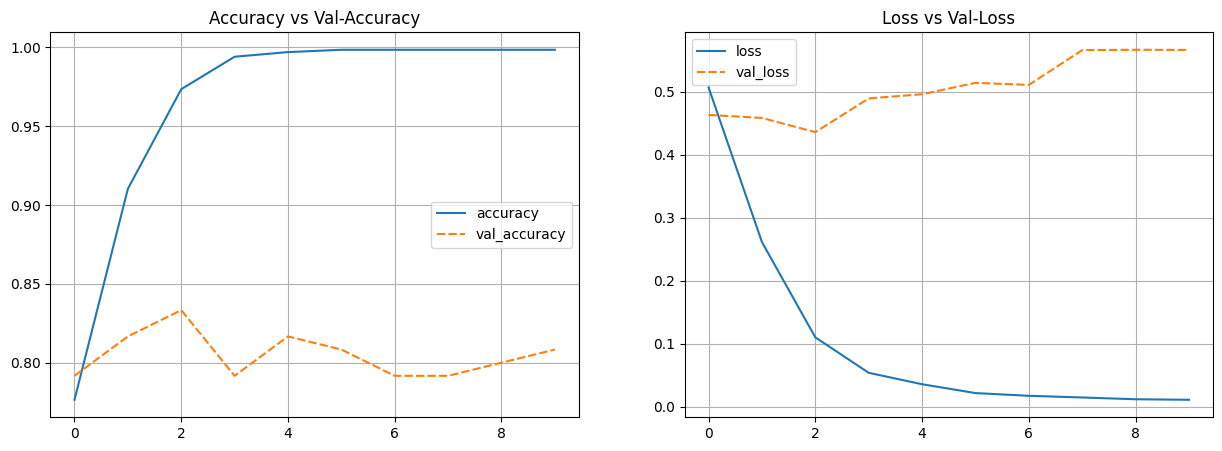

In [22]:
# Plot Training Results

model_rnn_hist_df = pd.DataFrame(model_rnn_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_rnn_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_rnn_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

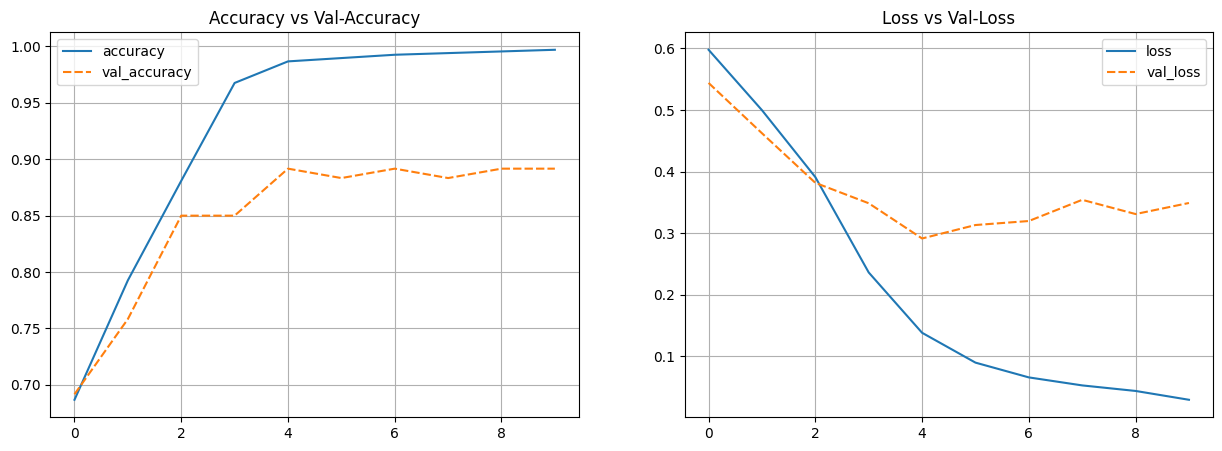

In [23]:
# Plot Training Results

model_lstm_hist_df = pd.DataFrame(model_lstm_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [24]:
# Download the Embedding Layer

url = 'https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1'

hub_layer = tf_hub.KerasLayer(url, output_shape=[128], input_shape=[], dtype=tf.string)

In [25]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [26]:
# Model Training using LSTM with Transfer Learning

## Define the architecture
model_LSTM_2 = Sequential()
model_LSTM_2.add(hub_layer)
model_LSTM_2.add(Reshape((128, 1)))
model_LSTM_2.add(Bidirectional(LSTM(128, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_LSTM_2.add(Dropout(0.5))
model_LSTM_2.add(Bidirectional(LSTM(64, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_LSTM_2.add(Dropout(0.5))
model_LSTM_2.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_LSTM_2.add(Dropout(0.5))
model_LSTM_2.add(Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_LSTM_2.add(Dropout(0.5))
model_LSTM_2.add(Bidirectional(LSTM(8, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_LSTM_2.add(Dropout(0.5))
model_LSTM_2.add(Dense(2, activation='softmax'))

model_LSTM_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [27]:
# Define ModelCheckpoint
model_checkpoint = ModelCheckpoint('deployment\\best_model.h5', monitor='val_loss', save_best_only=True)

model_LSTM_2_hist = model_LSTM_2.fit(X_train, y_train_ohe, epochs=75, validation_data=(X_val, y_val_ohe), callbacks=[model_checkpoint])

Epoch 1/75
22/22 [==============================] - 67s 1s/step - loss: 0.6455 - accuracy: 0.6794 - val_loss: 0.6002 - val_accuracy: 0.6917
Epoch 2/75
22/22 [==============================] - 19s 858ms/step - loss: 0.5690 - accuracy: 0.7118 - val_loss: 0.5172 - val_accuracy: 0.7167
Epoch 3/75
22/22 [==============================] - 16s 745ms/step - loss: 0.5491 - accuracy: 0.7294 - val_loss: 0.5386 - val_accuracy: 0.7000
Epoch 4/75
22/22 [==============================] - 18s 802ms/step - loss: 0.5661 - accuracy: 0.7132 - val_loss: 0.5018 - val_accuracy: 0.7417
Epoch 5/75
22/22 [==============================] - 18s 816ms/step - loss: 0.5150 - accuracy: 0.7588 - val_loss: 0.4826 - val_accuracy: 0.7333
Epoch 6/75
22/22 [==============================] - 17s 793ms/step - loss: 0.5254 - accuracy: 0.7456 - val_loss: 0.4818 - val_accuracy: 0.7167
Epoch 7/75
22/22 [==============================] - 16s 712ms/step - loss: 0.5247 - accuracy: 0.7221 - val_loss: 0.4891 - val_accuracy: 0.7500
Ep

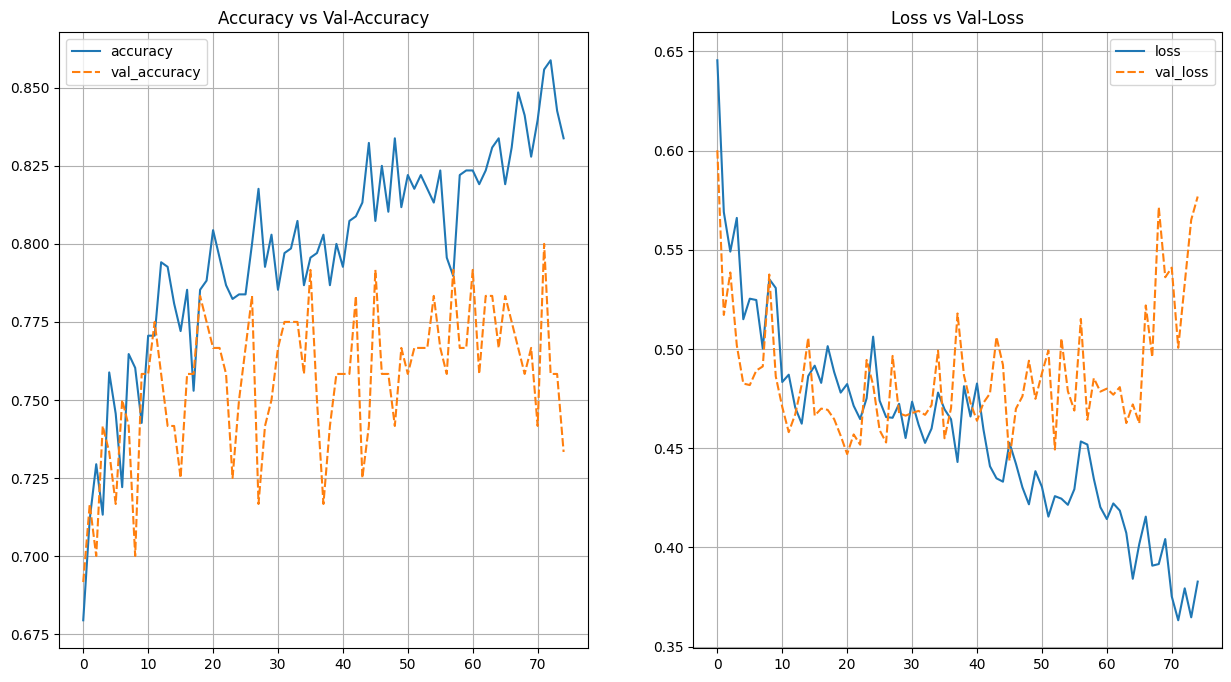

In [28]:
# Plot Training Results

model_LSTM_2_hist_df = pd.DataFrame(model_LSTM_2_hist.history)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_LSTM_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_LSTM_2_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [30]:
with custom_object_scope({'KerasLayer': tf_hub.KerasLayer}):
    model = load_model('deployment\\best_model.h5')


# Predict the values from the test data
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert test observations to one hot vectors
y_true = np.argmax(y_test_ohe, axis = 1)

# compute the confusion matrix
classificationReport = classification_report(y_true, y_pred_classes, target_names = ['negative', 'positive'])

print('Classification Report')
print(classificationReport)

7/7 [==============================] - 15s 389ms/step
Classification Report
              precision    recall  f1-score   support

    negative       0.81      0.88      0.84       138
    positive       0.67      0.55      0.60        62

    accuracy                           0.78       200
   macro avg       0.74      0.71      0.72       200
weighted avg       0.77      0.78      0.77       200



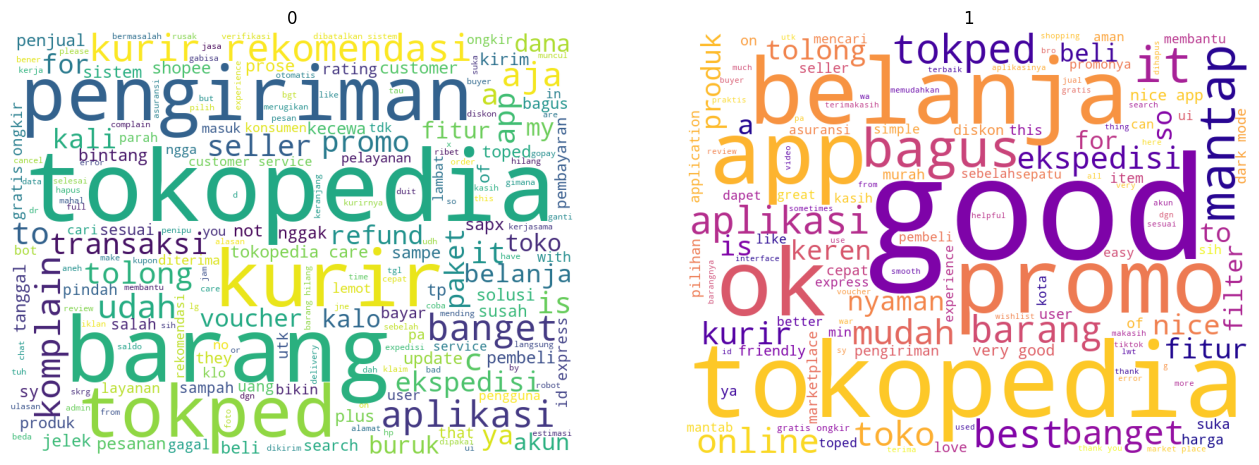

In [34]:
# Group the data by the category column
groups = df.groupby('Sentiment')

# List of colormaps
colormaps = ['viridis', 'plasma']
color = 0

# set the English stopwords
stop_words = set(stopwords.words('indonesian'))
stop_words.update(['the', 'yg', 'gk', 'nya', 'gak', 'pake', 'pakai', 'i','ga', "and"])

# Create a figure
fig, axes = plt.subplots(1, 2, figsize=(16, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each category and create a word cloud
for i, (name, group) in enumerate(groups):
    # Get the text data
    text = ' '.join(group['review_description'])
    
    # Create a word cloud object
    wc = wordcloud.WordCloud(width=800, height=600, background_color='white', stopwords=stop_words, min_font_size=10, colormap=colormaps[color])
    color += 1
    
    # Generate the word cloud from the text data
    wc.generate(text)
    
    # Plot the word cloud on the subplot
    axes[i].imshow(wc)
    axes[i].set_title(name)
    axes[i].axis('off')

# Remove the unused subplot (if any)
if len(groups) < len(axes):
    fig.delaxes(axes[-1])

# Show the figure
plt.show()

In [95]:
def is_prime(n):
    if n <= 1:
        return False
    if n <= 3:
        return True
    if n % 2 == 0 or n % 3 == 0:
        return False
    i = 5
    while i * i <= n:
        if n % i == 0 or n % (i + 2) == 0:
            return False
        i += 6
    return True

def foo_bar(num):
    if num % 3 == 0 and num % 5 == 0:
        return "FooBar"
    elif num % 3 == 0:
        return "Foo"
    elif num % 5 == 0:
        return "Bar"
    else:
        return str(num)

numbers = list(range(1, 101))
numbers.reverse()

for num in numbers:
    if not is_prime(num):
        print(foo_bar(num), end=" ")

Bar Foo 98 Foo Bar 94 Foo 92 91 FooBar 88 Foo 86 Bar Foo 82 Foo Bar Foo 77 76 FooBar 74 Foo Bar Foo 68 Foo Bar 64 Foo 62 FooBar 58 Foo 56 Bar Foo 52 Foo Bar 49 Foo 46 FooBar 44 Foo Bar Foo 38 Foo Bar 34 Foo 32 FooBar 28 Foo 26 Bar Foo 22 Foo Bar Foo 16 FooBar 14 Foo Bar Foo 8 Foo 4 1 

In [102]:
for num in numbers:
    if not is_prime(num):
        print(num,end=" ")

100 99 98 96 95 94 93 92 91 90 88 87 86 85 84 82 81 80 78 77 76 75 74 72 70 69 68 66 65 64 63 62 60 58 57 56 55 54 52 51 50 49 48 46 45 44 42 40 39 38 36 35 34 33 32 30 28 27 26 25 24 22 21 20 18 16 15 14 12 10 9 8 6 4 1 

In [110]:
for num in numbers:
    if not is_prime(num):
        print(num,end=" ")

100 99 98 96 95 94 93 92 91 90 88 87 86 85 84 82 81 80 78 77 76 75 74 72 70 69 68 66 65 64 63 62 60 58 57 56 55 54 52 51 50 49 48 46 45 44 42 40 39 38 36 35 34 33 32 30 28 27 26 25 24 22 21 20 18 16 15 14 12 10 9 8 6 4 1 

In [106]:
def is_prime(n):
    if n <= 1:
        return False
    if n == 2 or n == 3 or n == 5:
        return True
    if n % 2 == 0 or n % 3 == 0 or n % 5 == 0:
        return False
    i = 6
    while i * i <= n:
        if n % (i-1) == 0 or n % (i + 1) == 0:
            return False
        i += 6
    return True

In [108]:
is_prime(1)

False

In [113]:
for num in numbers:
    print(num,end= " ")

100 99 98 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76 75 74 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 

In [114]:
import math

In [119]:
n = 10
def prime_check(n):
    for i in range(sqrt_n, n + 1):
        print(i)

In [123]:
import math
def prime_check(n):
    for i in range(2, int(math.sqrt(n))+1):
        if n == 2 :
            print(n)
        if n % i == 0:
            print(99)

In [127]:
def prime_check(n):
    if n == 2:
        return True  # 2 is a prime number
    if n < 2 or n % 2 == 0:
        return False  # Numbers less than 2 and even numbers greater than 2 are not prime

    # Loop through odd numbers from 3 to square root of n
    for i in range(3, int(math.sqrt(n)) + 1, 2):
        if n % i == 0:
            return False  # n is divisible by i, hence not a prime number
    return True  # If no divisor is found, n is a prime number

In [ ]:
for num in numbers:
    if not is_prime(num):
        print(num,end=" ")

In [137]:
def prime_check(n):
    if n == 2:
        return True  # 2 is a prime number
    if n < 2 or n % 2 == 0:
        return False  # Numbers less than 2 and even numbers greater than 2 are not prime

    # Loop through odd numbers from 3 to square root of n
    for i in range(3, int(n**0.5) + 1, 2):
        if n % i == 0:
            return False  # n is divisible by i, hence not a prime number
    return True  # If no divisor is found, n is a prime number

numbers = list(range(1, 101))
numbers.reverse()

for num in numbers:
    if prime_check(num):
        print(num)

97
89
83
79
73
71
67
61
59
53
47
43
41
37
31
29
23
19
17
13
11
7
5
3
2
